""

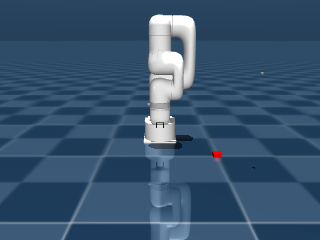

In [36]:
# import gym_lite6.env, gym_lite6.pickup_task, gym_lite6.utils
# import gymnasium as gym
import numpy as np
import mediapy as media
import mujoco
# from importlib import reload
from pathlib import Path

# reload(gym_lite6.env)
# reload(gym_lite6.utils)
# reload(gym_lite6.pickup_task)

qpos0 = None
box_pos0 = None
box_quat0 = None

# qpos0 = np.array([0, 0.4, 1 , 2.961, -0.5, 0.203])
# # qpos0 = np.array([0, 0.541, 1.49 , 2.961, 0.596, 0.203])
# box_pos0 = np.array([0.2, 0, 0.0])
# box_quat0 = None


# task = gym_lite6.pickup_task.GraspAndLiftTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')
# env = gym.make(
#     "UfactoryCubePickup-v0",
#     task=task,
#     obs_type="pixels_state",
#     action_type="qvel",
#     max_episode_steps=300,
#     visualization_width=320,
#     visualization_height=240,
#     render_fps=30
# )
# observation, info = env.reset(seed=69, qpos=qpos0, box_pos=box_pos0, box_quat=box_quat0)
# media.show_images([observation["pixels"]["gripper"], observation["pixels"]["side"]])
scene_path = Path("../gym_lite6/models/cube_pickup_large.xml")
model = mujoco.MjModel.from_xml_path(str(scene_path))
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data, 0)
media.show_image(renderer.render())

joint_qpos = [0, 1, 2, 3, 4, 5]
dof = len(joint_qpos)

# PRM


""

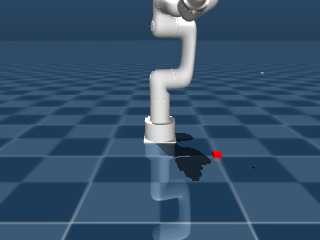

In [49]:
q = np.random.uniform(low=model.jnt_range[:6, 0], high=model.jnt_range[:6, 1])
q2 = np.random.uniform(low=model.jnt_range[:6, 0], high=model.jnt_range[:6, 1])
data.qpos[:6] = q
mujoco.mj_forward(model, data)
renderer.update_scene(data, 0)
media.show_image(renderer.render())

if any(np.isin(data.contact.geom.flatten(), np.arange(1, 17))):
    print("Collision")

In [ ]:
import heapq
import math

def validConfiguration(q):
  data.qpos[:6] = q
  mujoco.mj_forward(model, data)

  # Check collisions between any of the links
  if any(np.isin(data.contact.geom.flatten(), np.arange(1, 17))):
    return False
  
  return True

# def config_dist(q1, q2):
#   """
#   Similarity between two vectors
#   """
#   assert(q1.size == q2.size)
#   # return np.linalg.norm(q1-q2)
#   return abs(np.dot(q1, q2) / (np.linalg.norm(q1) * np.linalg.norm(q2)))


# def nearest_neighbours(query, adj_list, k):
#   min_heap = []
#   # Save distances to query point
#   for idx, (node, _) in enumerate(adj_list):
#     min_heap.append((config_dist(query, node), idx))
#   heapq.heapify(min_heap)

#   # Get top k
#   out = []
#   for i in range(k):
#     if (len(min_heap) == 0):
#       break
#     out.append(heapq.heappop(min_heap))
#   return out

def nearest_neighbours_vec(query, adj_list, k, radius):
  """
  Vectorised implementation of finding k nearest neighbours
  Returns:
    List length k or less, [(dist, index),]
  """
  if len(adj_list) == 0:
    return []
  coords = np.array([a[0] for a in adj_list])

  # Cosine dist - doesn't work well
  # dists = np.abs(query @ coords.T/(np.linalg.norm(coords, axis=1) * np.linalg.norm(query)))
  
  # L2 dist
  dists = np.linalg.norm(coords - query, axis=1)
  # print(dists)

  min_heap = [(d, i) for i,d in enumerate(dists)]
  heapq.heapify(min_heap)
  out = []
  for i in range(k):
    if (len(min_heap) == 0):
      break
    d = heapq.heappop(min_heap)
    if d[0] > radius:
      break
    out.append(d)
  return out

def visible(q1, q2, epsilon):
  """
  Can we draw a collision straight line between the two configurations
  q1 and q2 assumed feasible
  Recursive approach - bisects into smaller gaps
  O(norm(q1-q2)/epsilon)
  """
  if np.linalg.norm(q1 - q2) <= epsilon:
    return True

  # Cosine similarity version - doesn't play too well with bisection
  # if dist(q1, q2) <= epsilon:
  #   return True

  mid = (q1 + q2) / 2
  if not validConfiguration(mid):
    return False
  
  return visible(q1, mid, epsilon) and visible (q2, mid, epsilon)
  
def constructPRM(n_samples, k=5, epsilon=0.1, radius=1):
  # [coords: np.array(ndof), neighbours: list]
  adj_list = []
  rejections = []
  i = 0
  # For each sample
  while i < n_samples:
    # Random sample in joint range
    q = np.random.uniform(low=model.jnt_range[:6, 0], high=model.jnt_range[:6, 1])
    if not validConfiguration(q):
      rejections.append(q)
      continue
    adj_list.append([q, set()])
    nn = nearest_neighbours_vec(q, adj_list, k, radius)
    for n in nn:
      if visible(q, adj_list[n[1]][0], epsilon):
        adj_list[n[1]][1].add(i) # Append new node to neighbour adjacency
        adj_list[i][1].add(n[1]) # Append neighbour to nearest node adjacency
    i += 1

  # for i, (q, _) in enumerate(adj_list):
  #   # nn: [(dist1, idx1), (dist2, idx2) ...]
  #   nn = nearest_neighbours_vec(q, adj_list, k)
  #   for n in nn:
  #     if visible(q, adj_list[n[1]][0], epsilon):
  #       adj_list[n[1]][1].add(i) # Append new node to neighbour adjacency
  #       adj_list[i][1].add(n[1]) # Append neighbour to nearest node adjacency

  
  return adj_list, rejections

def searchPRM(adj_list, start, goal):
  # A*
  # bidirectional bfs ?
  def norm(node1, node2=goal, ord=2):
    # return dist(adj_list[node1][0], adj_list[node2][0])
    return np.linalg.norm(adj_list[node1][0]-adj_list[node2][0], ord=ord)
  
  heap = [(0, start)]
  visited = set()
  dists = [math.inf for _ in adj_list]
  dists[start] = 0
  predecessors = [None for _ in adj_list]
  
  while heap:
    sum, i = heapq.heappop(heap)

    if (i==goal):
      visited.add(i)
      break

    if i in visited:
      continue

    visited.add(i)

    for neighbour in adj_list[i][1]:
      heur = norm(neighbour, ord=2)
      d = norm(i, neighbour) # we don't have distances between 
      if dists[i] + d < dists[neighbour]:
        predecessors[neighbour] = i
        dists[neighbour] = dists[i] + d
        heapq.heappush(heap, (sum+d+heur, neighbour))
    # print(i, heap)
  
  if goal not in visited:
    return None, None

  # Reconstruct path from predecessors
  n = goal
  path = [goal]
  while n != start:
    n = predecessors[n]
    path.append(n)
  path.reverse()
  return dists[goal], path

def plan_q(prm, start_q, goal_q, radius=5):
  """
  Given start and end configurations, return waypoints between them in configuration space
  """
  start_node = nearest_neighbours_vec(start_q, prm, k=1, radius=radius)
  if len(start_node) == 0:
    raise ValueError(f"No neighbour to start node within radius {radius}")
  goal_node = nearest_neighbours_vec(goal_q, prm, k=1, radius=radius)
  if len(goal_node) == 0:
    raise ValueError(f"No neighbour to goal node within radius {radius}")

  # Extract the index of the node
  start_node = start_node[0][1]
  goal_node = goal_node[0][1]
  
  _, path = searchPRM(prm, start_node, goal_node)
  path = [start_q] + [prm[i][0] for i in path] + [goal_q]
  return path

In [508]:
q1 = np.random.uniform(low=model.jnt_range[:6, 0], high=model.jnt_range[:6, 1])
q2 = np.random.uniform(low=model.jnt_range[:6, 0], high=model.jnt_range[:6, 1])
q3 = np.random.uniform(low=model.jnt_range[:6, 0], high=model.jnt_range[:6, 1])
# print(dist(q1, q2), dist(q2, q3), dist(q1, q3))

In [509]:
adj_list = [[q2, [1]], [q3, [0]]]

In [510]:
print(q1, q2, q3, sep="\n")

[ 4.65148151 -2.4461552   4.46143226  4.40348459  1.76395013 -4.94461157]
[-4.27226596  0.18418154  4.5952476  -1.38676008  1.67037958  4.78593564]
[ 5.32516602  2.01405179  0.81539186 -1.81592306  1.50443969  1.0287907 ]


In [576]:
nearest_neighbours_vec(q1, adj_list, 2, 1)

[]

In [515]:
coords = np.array([a[0] for a in adj_list])
np.abs((q1 @ coords.T)/(np.linalg.norm(coords, axis=1) * np.linalg.norm(q1)))

array([0.33486541, 0.21311505])

In [527]:
prm, rej = constructPRM(10, k=2, radius=10)
# for n in prm:
#     n[0]=n[0][:2]
print(*prm, sep="\n")
dist, path = searchPRM(prm, 1, 8)
print(dist, path)

[array([-5.96792118, -1.06590573,  1.65138681, -5.31384467, -1.16700189,
        3.79109925]), {0}]
[array([-4.13875115,  0.29536801,  2.35966974,  4.36757081,  0.2558465 ,
        2.23665922]), {1, 2, 4}]
[array([ 1.44683729, -1.1226313 ,  4.97984273, -2.07070207, -0.98513028,
        0.48840505]), {1, 2, 3, 9}]
[array([5.09524311, 0.04719516, 0.8317193 , 2.32095997, 1.62355609,
       4.1089285 ]), {8, 2, 3, 7}]
[array([-5.57178128, -2.30813348,  1.14894747,  0.09086104,  0.9849416 ,
        1.12066694]), {1, 4}]
[array([ 3.82836894, -1.37132074,  2.15000219,  4.29321003, -1.48847642,
       -2.99040899]), {5, 6}]
[array([ 5.26375905, -0.24350471,  3.1867967 , -2.19123041, -0.69649675,
       -6.12601896]), {5, 6}]
[array([ 1.29455188, -2.14609125,  0.12462127,  2.22498733,  1.04433113,
        2.9985343 ]), {3, 7}]
[array([ 5.89604083, -0.40559836,  4.49297813, -1.13989353,  0.7139323 ,
        3.56156128]), {8, 3}]
[array([-0.4432513 , -0.24110729,  1.41136294, -5.82358463,  0.2100

In [ ]:
r = 10
avg = 0

for i in range(r):
  t1 = time.time()
  prm = constructPRM(100, k=2, epsilon=0.05)
  t2 = time.time()
  avg += (t2-t1)/r
print(avg)

k=1, connected() just returns True, do connections as we go
  Non vec
  n=100: 0.117s \
  n=1000:  6.02s

  Vec
  n=100: 0.0778s \
  n=1000: 1.23s

k=1, connected() just returns True, do connections after all samples created

  Non vec
  n=100: s \
  n=1000:  s

  Vec
  n=100: 0.077s \
  n=1000: 1.65s

connected checks visibility, 
  n=100
    epsilon=0.1
    k=1: 3.1s \
    k=2: 6.15s \
    k=5: 15.3s

    epsilon=0.05
    k=1: 6.3s \
    k=2:  \
    k=5: 

In [653]:
prm, rej = constructPRM(2000, k=8, epsilon=0.5, radius=2)

In [650]:
dist, path = searchPRM(prm, 6, 20)
print(dist, path)

0 [6, 988, 147, 472, 887, 1199, 1701, 836, 739, 1208, 20]


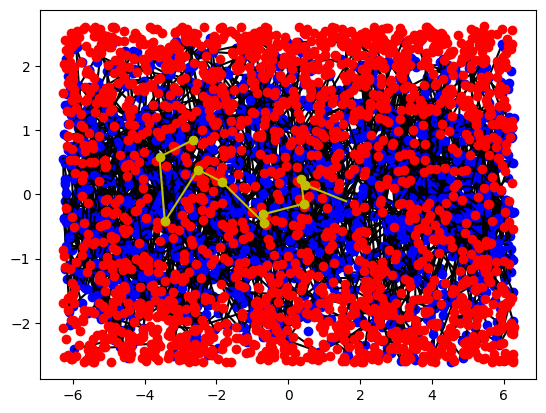

In [652]:
# Visualise PRM
import matplotlib.pyplot as plt

dims = [0, 1]
edges = set()



for i, (q, nn) in enumerate(prm):
  x, y = q[dims[0]], q[dims[1]]
  plt.plot(x, y, 'bo')
  for n in nn:
    # Line from current to nearest neighbour
    edge = tuple(sorted([i, n]))
    if edge not in edges:
      nx, ny = prm[n][0][dims[0]], prm[n][0][dims[1]]
      plt.plot([x, nx], [y, ny], 'k-')
      edges.add(edge)
for q in rej:
  plt.plot(q[dims[0]], q[dims[1]], 'ro')

for i in range(len(path)-1):
  n = path[i+1]
  q, _ = prm[path[i]]
  x, y = q[dims[0]], q[dims[1]]
  plt.plot(x, y, 'yo')
  # Line from current to nearest neighbour
  edge = tuple(sorted([i, n]))
  # if edge not in edges:
  nx, ny = prm[n][0][dims[0]], prm[n][0][dims[1]]
  plt.plot([x, nx], [y, ny], 'y-')
  edges.add(edge)


In [583]:
nearest_neighbours_vec(start_q, prm, k=1, radius=5)[0][1]

950

In [597]:
prm[0]

[array([-3.28207196,  0.7142935 ,  3.88467786,  3.04782224,  0.5098103 ,
        -4.38356095]),
 {0, 31, 51, 54, 61, 76, 96, 122, 158, 228, 247, 295, 315, 435, 555}]

In [ ]:
frames = []
for i in path:
  data.qpos[joint_qpos] = prm[i][0]
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, 0)
  frames.append(renderer.render())

media.show_images(frames)


In [ ]:
import sklearn
import sklearn.manifold

features = np.array([x[0] for x in prm])
tsne = sklearn.manifold.TSNE()
tsne_features = tsne.fit_transform(features)

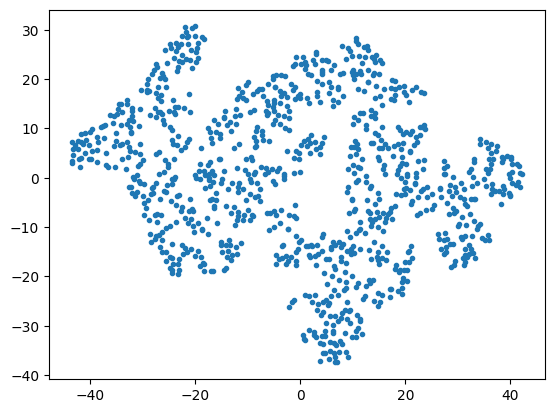

In [ ]:
plt.plot(tsne_features[:, 0],tsne_features[:, 1], '.')

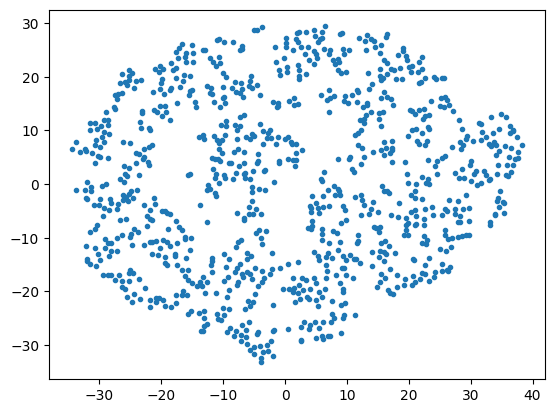

In [ ]:
rej_tsne = tsne.fit_transform(np.array(rej))
plt.plot(rej_tsne[:, 0],rej_tsne[:, 1], '.')

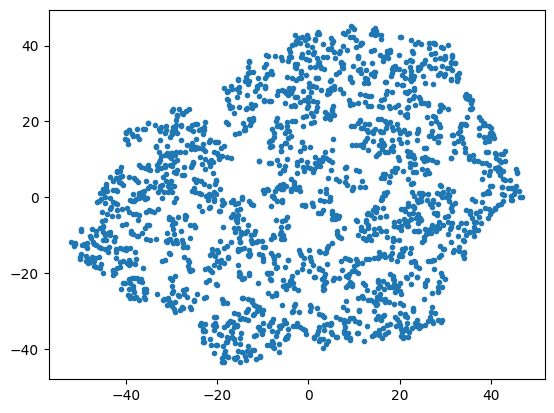

In [ ]:
concat_features = np.vstack((features, np.array(rej)))
labels = np.ones(concat_features.shape[0])
labels[:len(features)] = 0
concat_tsne = tsne.fit_transform(concat_features)
plt.plot(concat_tsne[:, 0],concat_tsne[:, 1], '.')


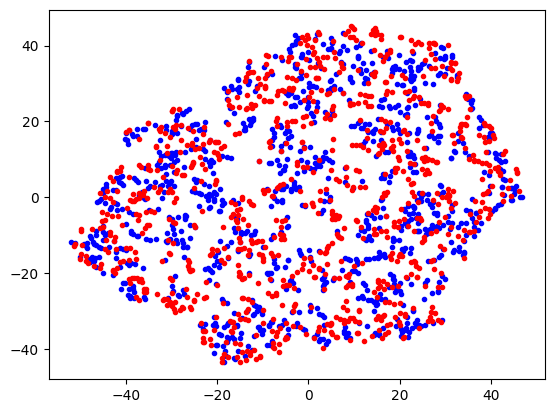

In [ ]:
plt.plot(concat_tsne[:len(features), 0],concat_tsne[:len(features), 1], 'b.')
plt.plot(concat_tsne[len(features):, 0],concat_tsne[len(features):, 1], 'r.')


""

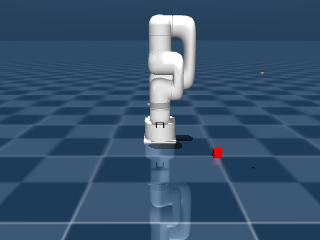

""

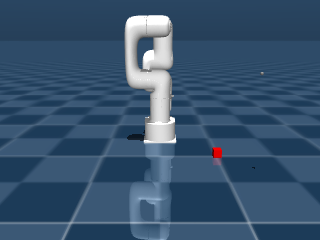

In [617]:
start_q = np.array([0, 0, 0, 0, 0, 0])
end_q = np.array([3, 0, 0, 0, 0, 0])

data.qpos[joint_qpos] = start_q
mujoco.mj_forward(model, data)
renderer.update_scene(data, 0)
media.show_image(renderer.render())

data.qpos[joint_qpos] = end_q
mujoco.mj_forward(model, data)
renderer.update_scene(data, 0)
media.show_image(renderer.render())

In [654]:
waypoints = plan_q(prm, start_q, end_q)
print(waypoints)

[array([0, 0, 0, 0, 0, 0]), array([-0.07256742, -0.08997829,  0.19659022, -0.96796485, -0.70420759,
       -0.39946176]), array([-1.01606227, -1.13693143,  0.8411948 , -0.31295337, -1.24989569,
        0.14237479]), array([-0.45896041, -0.12425467,  0.25164773,  0.19153406, -1.48187757,
        1.19860585]), array([ 0.3418043 , -0.75743208,  0.39982434, -0.28164143, -0.575044  ,
        1.77274099]), array([ 0.81332301, -0.44596215,  0.14540782,  0.38618574,  0.01311874,
        1.25350697]), array([ 1.6038511 , -0.03152805,  0.37824387,  0.43184581, -0.2868265 ,
       -0.2436727 ]), array([3, 0, 0, 0, 0, 0])]


,,,,,,,

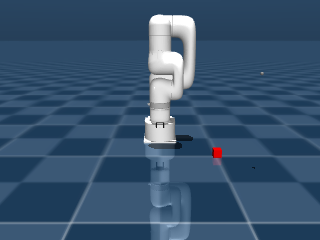
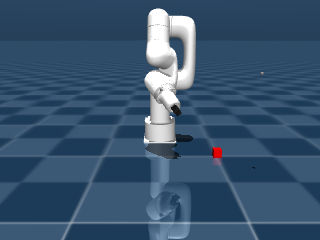
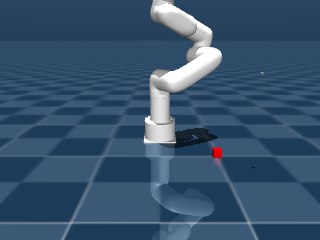
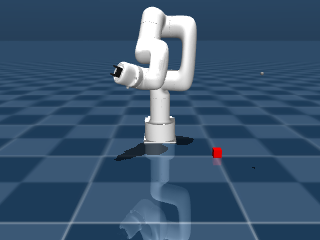
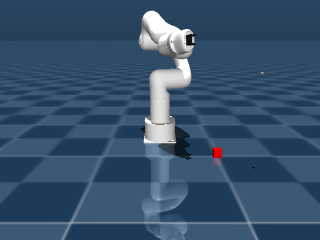
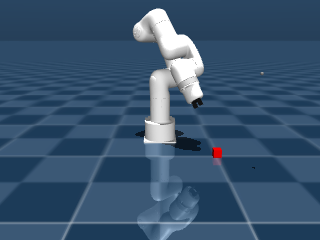
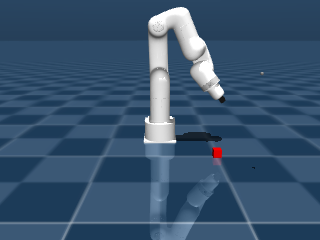
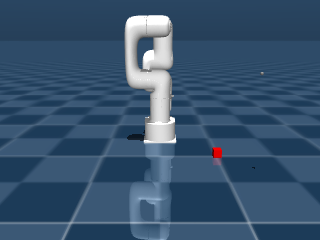

In [655]:
frames = []
for w in waypoints:
  data.qpos[joint_qpos] = w
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, 0)
  frames.append(renderer.render())

media.show_images(frames)

In [558]:
group_id = 1 # 1 for vel control, 2 for pos control
model.opt.disableactuator = 2**group_id
# group 0 is our gripper, here we just want the robot joints
joint_actuators = [x for x in range(model.nu) if model.actuator(x).group != group_id and model.actuator(x).group != 0]

In [657]:
# Follow straight line paths or interpolate joint angles
# Joint angles probably easier
# waypoints = [prm[i][0] for i in path]
max_vel = 0.8 # rad/s joint angles
ctrl_rate = 30

# Start the sim at 1st waypoint
mujoco.mj_resetData(model, data)
data.qpos[joint_qpos] = waypoints[0]
mujoco.mj_forward(model, data)
stage = 1

frames = []

while stage < len(waypoints) and len(frames) < 300:
  q_curr = data.qpos[joint_qpos]
  q_err = waypoints[stage] - q_curr
  # print(q_curr, waypoints[stage], q_err)

  q_vel = q_err / np.max(np.abs(q_err)) * max_vel # simply scale error to maximum velocity
  data.ctrl[joint_actuators] = q_vel
  
  for _ in range(int(1/(ctrl_rate*model.opt.timestep))):
    mujoco.mj_step(model, data)
  renderer.update_scene(data, 0)
  frames.append(renderer.render())
  # If we've reached the target
  if np.linalg.norm(q_err) < 0.1:
    stage += 1
    print(stage)
    # q_err = waypoints[stage] - q_curr

# Stay a little
for i in range(30):
  data.ctrl[joint_actuators] = np.zeros_like(joint_actuators)
  for _ in range(int(1/(ctrl_rate*model.opt.timestep))):
    mujoco.mj_step(model, data)
  renderer.update_scene(data, 0)
  frames.append(renderer.render())

media.show_video(frames, fps=ctrl_rate);


2
3
4
5
6
7
8


In [627]:
q_err = np.array([ 0.04471634, -0.45139673, -0.27441342, -0.10896055, -0.09942893, -0.92020322])
np.max(q_err)

0.04471634

In [ ]:
import math
def dijkstra(adj_list, start, end):
  """
  cumulative weights
  Means we can just break when we find the node
  """
  heap = [(0, start)]
  visited = set()
  
  while heap:
    sum, i = heapq.heappop(heap)

    if (i==end):
      return sum

    if i in visited:
      continue

    visited.add(i)

    for dist, neighbour in adj_list[i]:
      heapq.heappush(heap, (sum+dist, neighbour))
    print(i, heap)


def dijkstra2(adj_list, start, end):
  """
  Incremental weights, track dists
  """
  heap = [(0, start)]
  dists = [math.inf for _ in adj_list]
  dists[start] = 0
  visited = set()
  
  while heap:
    d, i = heapq.heappop(heap)

    if (i==end):
      return dists[i]

    if i in visited:
      continue

    visited.add(i)

    for n_dist, neighbour in adj_list[i]:
      if (dists[neighbour] > dists[i]+n_dist):
        dists[neighbour] = dists[i] + n_dist
        heapq.heappush(heap, (n_dist, neighbour))
    
    print(i, heap)
  
  return dists[end]




In [ ]:
# (dist, idx) - heap sorts by first
adj_list = [[(1, 1), (3, 3), (12, 5)], [(1, 0), (2,3), (1, 4), (2,2)], [(2,1),(1,4),(10,5)], [(2, 1), (3, 0)], [(1, 1), (1, 2)], [(10, 2), (12,0)]]
# out = dijkstra(adj_list, 0, 2)
# assert out == 3, out
# out = dijkstra(adj_list, 0, 4)
# assert out == 2, out
# out = dijkstra(adj_list, 3, 0)
# assert out == 3, out
out = dijkstra(adj_list, 0, 5)
assert out == 12, out

# out = dijkstra2(adj_list, 0, 2)
# assert out == 3, out
# out = dijkstra2(adj_list, 0, 4)
# assert out == 2, out
# out = dijkstra2(adj_list, 3, 0)
# assert out == 3, out
out = dijkstra2(adj_list, 0, 5)
assert out == 12, out


0 [(1, 1), (3, 3), (12, 5)]
1 [(2, 0), (2, 4), (3, 2), (12, 5), (3, 3), (3, 3)]
4 [(3, 1), (3, 2), (3, 2), (12, 5), (3, 3), (3, 3)]
2 [(3, 2), (3, 3), (3, 3), (12, 5), (5, 1), (4, 4), (13, 5)]
3 [(3, 3), (5, 1), (4, 4), (12, 5), (13, 5), (5, 1), (6, 0)]
0 [(1, 1), (3, 3), (12, 5)]
1 [(1, 4), (2, 2), (3, 3), (12, 5)]
4 [(2, 2), (12, 5), (3, 3)]
2 [(3, 3), (12, 5)]
3 [(12, 5)]
